In [58]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score,fbeta_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [2]:
os.chdir(r'D:\use case\Loan Default Prediction\data')

In [3]:
df = pd.read_csv('processed_data.csv')

In [ ]:
df.head(10)

In [ ]:
df.Default.dtype

In [4]:
# Step 1: Convert all categorical columns to object, excluding 'Score_Source_2', 'Score_Source_3'
categorical_columns = [col for col in df.columns if col not in ['Score_Source_2', 'Score_Source_3']]
df[categorical_columns] = df[categorical_columns].astype('object')


In [5]:
# If it's numeric but string-like:
df['Default'] = df['Default'].astype(int)

In [6]:
# Step 2: Split into features and target
X = df.drop('Default', axis=1)
y = df['Default']

In [7]:
# Step 3: Define preprocessing pipelines
numeric_features = ['Score_Source_2', 'Score_Source_3']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [8]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [35]:
# Step 4: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
X_train

In [36]:
# Step 5: Fit preprocessing pipeline to training data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [11]:
# Step 6: Train logistic regression on preprocessed data
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_prepared, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [12]:
# Step 7: Make predictions
y_pred = model.predict(X_test_prepared)
y_prob = model.predict_proba(X_test_prepared)[:, 1]  # for ROC-AUC

In [13]:
# Step 8: Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     33619
           1       0.56      0.01      0.01      2938

    accuracy                           0.92     36557
   macro avg       0.74      0.50      0.48     36557
weighted avg       0.89      0.92      0.88     36557

Accuracy: 0.9197144185792051
Precision: 0.5555555555555556
Recall: 0.0051055139550714775
F1 Score: 0.01011804384485666
ROC AUC Score: 0.7278473482257057


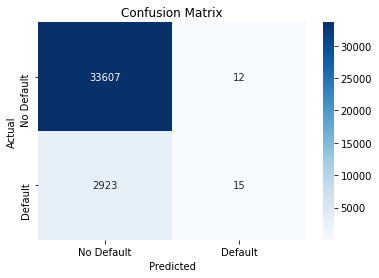

In [14]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
xgb1 = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)

In [23]:
xgb1.fit(X_train_prepared,y_train)

C:\Users\biswa\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [02:17:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [24]:
 # Predict
y_pred = model.predict(X_test_prepared)
y_prob = model.predict_proba(X_test_prepared)[:, 1]
  
results = []
    # Evaluate
results.append({
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

# Create a DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)

In [67]:
results

[{'Model': 'XGBoost',
  'Accuracy': 0.9197144185792051,
  'Precision': 0.5555555555555556,
  'Recall': 0.0051055139550714775,
  'F1 Score': 0.01011804384485666,
  'ROC AUC': 0.7278473482257057}]

In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Store results
results = []

# Loop through models
for name, model in models.items():
    # For Naive Bayes: it doesn't work with sparse matrix (from OneHotEncoder), convert to dense
    X_train_mod = X_train_prepared.toarray() if name == 'Naive Bayes' else X_train_prepared
    X_test_mod = X_test_prepared.toarray() if name == 'Naive Bayes' else X_test_prepared
    
    # Train
    model.fit(X_train_mod, y_train)
    
    # Predict
    y_pred = model.predict(X_test_mod)
    y_prob = model.predict_proba(X_test_mod)[:, 1]
    
    # Evaluate
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

# Create a DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)

In [27]:
# Step 1: Compute scale_pos_weight for imbalance
# Formula: count(negative class) / count(positive class)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 11.35


In [28]:
# Step 2: Define XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

In [38]:
# Step 3: Hyperparameter grid (basic but effective)
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}


In [39]:
# Step 4: Use recall as scoring metric
recall_scorer = make_scorer(recall_score)

In [108]:
# Step 4: Define F-beta scorer with beta = 3
fbeta_scorer = make_scorer(fbeta_score, beta=4)

In [52]:
# Step 5: Cross-validation with GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=fbeta_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [53]:
# Step 6: Fit model
grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\biswa\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.01],
                         'max_depth': [3], 'n_estimators': [100],
                         'subsample': [0.8]},
             scoring=make_scorer(fbeta_score, beta=0.8), verbose=1)

In [42]:
# Step 7: Best model and recall score
print("Best Parameters:\n", grid_search.best_params_)
print("Best Recall Score on CV:", grid_search.best_score_)




Best Parameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Recall Score on CV: 0.6095297876598995


In [68]:
# Step 8: Predict on test set using best estimator

y_pred_test = grid_search.best_estimator_.predict(X_test_prepared)

# Step 9: Evaluate on test data
print("Test Recall Score:", recall_score(y_test, y_pred_test))

Test Recall Score: 0.6010891763104153


In [69]:
results.append({
        'Model': 'grid_search_XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1 Score': f1_score(y_test, y_pred_test),
        'ROC AUC': roc_auc_score(y_test, y_pred_test)
    })

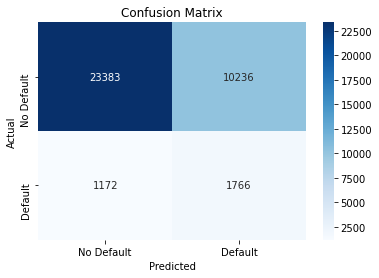

In [55]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [76]:
# Expanded hyperparameter grid for random search
param_distributions = {
    'n_estimators': [100, 200, 300,400,500],
    'max_depth': [3, 5, 7,9],
    'learning_rate': [0.01, 0.05, 0.1,0.3],
    'subsample': [0.2,0,4,0.6, 0.8],
    'colsample_bytree': [0.4,0.6, 0.8]
}

In [77]:
# RandomizedSearchCV with more parameter combinations
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    scoring=fbeta_scorer,
    cv=5,
    n_iter=50,  # You can adjust this depending on how many random combos you want to try
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [78]:
# Step 6: Fit model
random_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\biswa\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\biswa\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\biswa\anaconda3\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\biswa\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
  File "C:\Users\biswa\anaconda3\lib\site-packages\xgboost\core.py", line 72

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.6, 0.8],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.2, 0, 4, 0.6, 0.8]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=2.2),
                   verbose=2)

In [79]:
# Step 8: Predict on test set using best estimator

y_pred_test_random = random_search.best_estimator_.predict(X_test_prepared)

# Step 9: Evaluate on test data
print("Test Recall Score:", recall_score(y_test, y_pred_test_random))

Test Recall Score: 0.6507828454731109


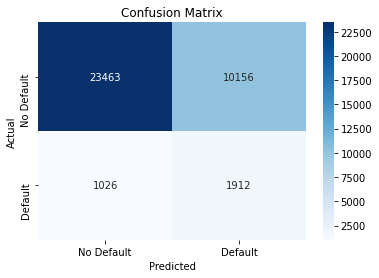

In [80]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test_random)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [81]:
results.append({
        'Model': 'random_search_XGBoost_modified',
        'Accuracy': accuracy_score(y_test, y_pred_test_random),
        'Precision': precision_score(y_test, y_pred_test_random),
        'Recall': recall_score(y_test, y_pred_test_random),
        'F1 Score': f1_score(y_test, y_pred_test_random),
        'ROC AUC': roc_auc_score(y_test, y_pred_test_random)
    })

In [82]:
# Create a DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)

In [83]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.919714,0.555556,0.005106,0.010118,0.727847
3,random_search_XGBoost_modified,0.694122,0.158436,0.650783,0.254831,0.674346
2,random_search_XGBoost,0.791640,0.198712,0.525187,0.288330,0.670057
1,grid_search_XGBoost,0.687939,0.147142,0.601089,0.236412,0.648309


In [74]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [109]:
random_search.best_params_

{'subsample': 0.6,
 'n_estimators': 500,
 'max_depth': 3,
 'learning_rate': 0.05,
 'colsample_bytree': 0.6}

In [110]:
param_grid = {
    'n_estimators': [500,450],
    'max_depth': [3, 5,7],
    'learning_rate': [0.05],
    'subsample': [0.6],
    'colsample_bytree': [0.6],
    'reg_alpha': [ 0.1, 0.2,0.3],          # L1 regularization
    'reg_lambda': [1, 1.5, 2]        # L2 regularization
}

In [115]:
# Step 5: Cross-validation with GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=fbeta_scorer,
    cv=3,
    n_jobs=1,
    verbose=3
)

In [117]:
import warnings
warnings.filterwarnings('ignore')

In [118]:
grid_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.6;, score=0.543 total time=   1.6s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.6;, score=0.553 total time=   1.6s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.6;, score=0.540 total time=   1.6s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6;, score=0.548 total time=   1.7s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6;, score=0.554 total time=   1.8s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1.5, subsamp

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.6], 'learning_rate': [0.05],
                         'max_depth': [3, 5, 7], 'n_estimators': [500, 450],
                         'reg_alpha': [0.1, 0.2, 0.3],
                         'reg_lambda': [1, 1.5, 2], 'subsample': [0.6]},
             scoring=make_scorer(fbeta_score, beta=4), verbose=3)

In [119]:
grid_search.best_score_

0.5480264018144329

In [128]:
grid_search.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 450,
 'reg_alpha': 0.2,
 'reg_lambda': 2,
 'subsample': 0.6}

In [120]:
# Step 8: Predict on test set using best estimator

y_pred_test_grid = grid_search.best_estimator_.predict(X_test_prepared)

# Step 9: Evaluate on test data
print("Test Recall Score:", recall_score(y_test, y_pred_test_grid))

Test Recall Score: 0.6531654186521443


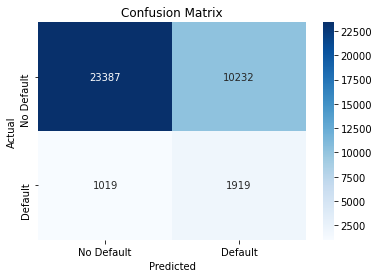

In [121]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test_grid)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [125]:
results.append({
        'Model': 'random_search_XGBoost_modified1',
        'Accuracy': accuracy_score(y_test, y_pred_test_grid),
        'Precision': precision_score(y_test, y_pred_test_grid),
        'Recall': recall_score(y_test, y_pred_test_grid),
        'F1 Score': f1_score(y_test, y_pred_test_grid),
        'ROC AUC': roc_auc_score(y_test, y_pred_test_grid)
    })

In [126]:
# Create a DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)

In [127]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.919714,0.555556,0.005106,0.010118,0.727847
4,random_search_XGBoost_modified,0.692234,0.157929,0.653165,0.254357,0.674407
5,random_search_XGBoost_modified1,0.692234,0.157929,0.653165,0.254357,0.674407
3,random_search_XGBoost_modified,0.694122,0.158436,0.650783,0.254831,0.674346
2,random_search_XGBoost,0.791640,0.198712,0.525187,0.288330,0.670057
1,grid_search_XGBoost,0.687939,0.147142,0.601089,0.236412,0.648309


In [134]:
pip install --upgrade numpy


  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0



ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\biswa\\anaconda3\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [135]:
pip install --upgrade catboost


Requirement already up-to-date: catboost in c:\users\biswa\anaconda3\lib\site-packages (1.2.8)
Note: you may need to restart the kernel to use updated packages.


In [137]:
from catboost import CatBoostClassifier


# Define the CatBoostClassifier
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    auto_class_weights='Balanced'  # Automatically handles class imbalance
)

# Define the hyperparameter distributions
param_distributions = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1.0],
    'border_count': [32, 64, 128]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    scoring=fbeta_scorer,  # or 'f1_weighted'
    cv=5,
    n_iter=20,              # Try 20 random combinations
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit to training data
random_search.fit(X_train_prepared, y_train)

# Output best results
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [143]:
python --version

NameError: name 'python' is not defined